In [6]:
import librosa
import numpy as np
import pandas  as pd
from sklearn.ensemble import RandomForestClassifier
import tqdm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [7]:
def get_windows(audio, window_size):
    
    start = 0
    windows = []
    audio_len = len(audio)
    
    while start < audio_len:
        
        #find window end
        if start+window_size > audio_len:
            break
        else: 
            window_end = int(start + window_size)
            
        #take window 
        window = audio[start:window_end]
    
        windows.append(window)
        #move window
        start += int(window_size / 2) 
        
    return windows

train_csv = pd.read_csv('/home/michael/Documents/VScode/Uni/Advanced AI/project_ideas/archive/Metadata_Train.csv')
test_csv = pd.read_csv('/home/michael/Documents/VScode/Uni/Advanced AI/project_ideas/archive/Metadata_Test.csv')
test_csv['Class'].unique()

array(['Sound_Guiatr', 'Sound_Drum', 'Sound_Violin', 'Sound_Piano'],
      dtype=object)

In [8]:
x_train = []
y_train = []

labels = train_csv['Class'].unique()
#spelling error in the test_data we need to account for
label_encoder = {'Sound_Guiatr' : 0}
for index, label in enumerate(labels):
    label_encoder[label] = index

for index, row in tqdm.tqdm_notebook(train_csv.iterrows(), desc = 'tqdm() Progress Bar', total = len(train_csv)):
    
    orginal_filename = row['FileName']
    audio, sr = librosa.load(path = f'/home/michael/Documents/VScode/Uni/Advanced AI/project_ideas/archive/Train_submission/Train_submission/{orginal_filename}')
    windowed_audio = get_windows(audio, sr)
    
    for window in windowed_audio:
        # an average point at the center of the wave form 
        centroid = librosa.feature.spectral_centroid(y=window, sr=sr, n_fft=1024, hop_length=512)[0]
        #the point at which 85% of the spectral power lies 
        roll_off = librosa.feature.spectral_rolloff(y=window, sr=sr, n_fft=1024, hop_length=512)[0]
        # the width of a wave at the spectral centroid 
        bandwidth = librosa.feature.spectral_bandwidth(y=window, sr=sr, n_fft=1024, hop_length=512)[0]
        #the difference between the peaks and troughs 
        contrast = librosa.feature.spectral_contrast(y=window, sr=sr, n_fft=1024, hop_length=512)[0]
        #a comparison of the artithemic mean and geometric mean 
        flatness = librosa.feature.spectral_flatness(y=window, n_fft=1024, hop_length=512)[0]
        
        
        feature = [centroid, roll_off, bandwidth, contrast, flatness]
        label = label_encoder[row['Class']]
        
    x_train.append(feature)
    y_train.append(label)



/tmp/ipykernel_5147/538281309.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm.tqdm_notebook(train_csv.iterrows(), desc = 'tqdm() Progress Bar', total = len(train_csv)):


tqdm() Progress Bar:   0%|          | 0/2629 [00:00<?, ?it/s]

In [9]:
x_test = []
y_test = []

labels = test_csv['Class'].unique()
#spelling error in the test_data we need to account for
label_encoder = {'Sound_Guiatr' : 0}
for index, label in enumerate(labels):
    label_encoder[label] = index

for index, row in tqdm.tqdm_notebook(test_csv.iterrows(), desc = 'tqdm() Progress Bar', total = len(test_csv)):
    
    orginal_filename = row['FileName']
    audio, sr = librosa.load(path = f'/home/michael/Documents/VScode/Uni/Advanced AI/project_ideas/archive/Test_submission/Test_submission/{orginal_filename}')
    windowed_audio = get_windows(audio, sr)
    
    for window in windowed_audio:
        # an average point at the center of the wave form 
        centroid = librosa.feature.spectral_centroid(y=window, sr=sr, n_fft=1024, hop_length=512)[0]
        # the point at which 85% of the spectral power lies 
        roll_off = librosa.feature.spectral_rolloff(y=window, sr=sr, n_fft=1024, hop_length=512)[0]
        # the width of a wave at the spectral centroid 
        bandwidth = librosa.feature.spectral_bandwidth(y=window, sr=sr, n_fft=1024, hop_length=512)[0]
        # the difference between the peaks and troughs 
        contrast = librosa.feature.spectral_contrast(y=window, sr=sr, n_fft=1024, hop_length=512)[0]
        # a comparison of the artithemic mean and geometric mean 
        flatness = librosa.feature.spectral_flatness(y=window, n_fft=1024, hop_length=512)[0]
        
        feature = [centroid, roll_off, bandwidth, contrast, flatness]
        label = label_encoder[row['Class']]
        
    x_test.append(feature)
    y_test.append(label)

/tmp/ipykernel_5147/3840300626.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm.tqdm_notebook(test_csv.iterrows(), desc = 'tqdm() Progress Bar', total = len(test_csv)):


tqdm() Progress Bar:   0%|          | 0/80 [00:00<?, ?it/s]

In [28]:
np.shape(x_test)

(80, 220)

In [10]:
np.shape(x_train)
#shape is 2629 5, 44 for x train and 80, 5, 44 for x test
np.save('x_train', np.array(x_train).flatten())
np.save('y_train', np.array(y_train).flatten())
np.save('x_test', np.array(x_test).flatten())
np.save('y_test', np.array(y_test).flatten())


In [45]:
x_train = np.reshape(np.load('x_train.npy'), (2629, 5, 44))
y_train = np.reshape(np.load('y_train.npy'), (2629,))
x_test = np.reshape(np.load('x_test.npy'), (80, 5, 44))
y_test = np.reshape(np.load('y_test.npy'), (80,))

#[centroid, roll_off, bandwidth, contrast, flatness]
centroid_x, centroid_y = [], []
roll_off_x, roll_off_y = [], []
bandwidth_x, bandwidth_y = [], []
contrast_x, contrast_y = [], []
flatness_x, flatness_y = [], []

for index, multidim in enumerate(x_train):
    centroid_x.append(multidim[0])
    centroid_y.append(y_train[index])
    
    roll_off_x.append(multidim[1])
    roll_off_y.append(y_train[index])
    
    bandwidth_x.append(multidim[2])
    bandwidth_y.append(y_train[index])
    
    contrast_x.append(multidim[3])
    contrast_y.append(y_train[index])
    
    flatness_x.append(multidim[4])
    flatness_y.append(y_train[index])
    



In [50]:
centroid_testx, centroid_testy =[], []
roll_off_testx, roll_off_testy =[], []
bandwidth_testx, bandwidth_testy = [], []
contrast_testx, contrast_testy = [], []
flatness_testx, flatness_testy = [], []

for index, multidim in enumerate(x_test):
    centroid_testx.append(multidim[0])
    centroid_testy.append(y_test[index])
    
    roll_off_testx.append(multidim[1])
    roll_off_testy.append(y_test[index])
    
    bandwidth_testx.append(multidim[2])
    bandwidth_testy.append(y_test[index])
    
    contrast_testx.append(multidim[3])
    contrast_testy.append(y_test[index])
    
    flatness_testx.append(multidim[4])
    flatness_testy.append(y_test[index])

In [47]:
centroid_rf = RandomForestClassifier()
centroid_rf.fit(centroid_x, centroid_y)

roll_off_rf = RandomForestClassifier()
roll_off_rf.fit(roll_off_x, roll_off_y)

bandwidth_rf = RandomForestClassifier()
bandwidth_rf.fit(bandwidth_x, bandwidth_y)

contrast_rf = RandomForestClassifier()
contrast_rf.fit(contrast_x, contrast_y)

flatness_rf = RandomForestClassifier()
flatness_rf.fit(flatness_x, flatness_y)

RandomForestClassifier()

0.3875


<Figure size 720x576 with 0 Axes>

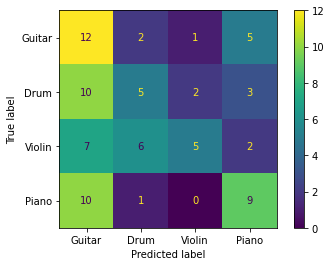

In [52]:
print(flatness_rf_score := flatness_rf.score(flatness_testx, flatness_testy))

y_pred = flatness_rf.predict(flatness_testx)

plt.figure(figsize=(10,8))
cm=ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred), display_labels=['Guitar', 'Drum', 'Violin', 'Piano'])#, display_labels = [False, True]) 
cm.plot()
plt.show()

0.35


<Figure size 720x576 with 0 Axes>

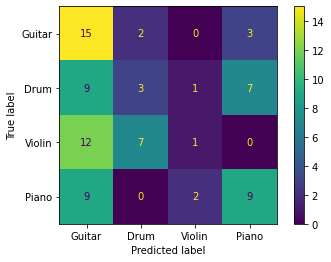

In [53]:
print(constrast_rf_score := contrast_rf.score(contrast_testx, contrast_testy))

y_pred = contrast_rf.predict(contrast_testx)

plt.figure(figsize=(10,8))
cm=ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred), display_labels=['Guitar', 'Drum', 'Violin', 'Piano'])#, display_labels = [False, True]) 
cm.plot()
plt.show()

0.3


<Figure size 720x576 with 0 Axes>

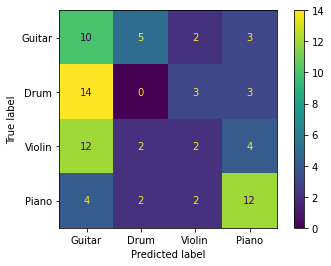

In [54]:
print(bandwidth_rf_score := bandwidth_rf.score(bandwidth_testx, bandwidth_testy))

y_pred = bandwidth_rf.predict(bandwidth_testx)

plt.figure(figsize=(10,8))
cm=ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred), display_labels=['Guitar', 'Drum', 'Violin', 'Piano'])#, display_labels = [False, True]) 
cm.plot()
plt.show()

0.3625


<Figure size 720x576 with 0 Axes>

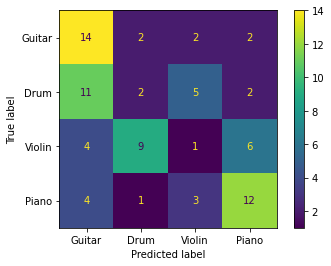

In [55]:
print(roll_off_rf_score := roll_off_rf.score(roll_off_testx, roll_off_testy))

y_pred = roll_off_rf.predict(roll_off_testx)

plt.figure(figsize=(10,8))
cm=ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred), display_labels=['Guitar', 'Drum', 'Violin', 'Piano'])#, display_labels = [False, True]) 
cm.plot()
plt.show()

0.4125


<Figure size 720x576 with 0 Axes>

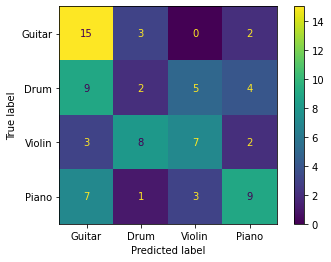

In [57]:
print(centroid_rf_score := centroid_rf.score(centroid_testx, centroid_testy))

y_pred = centroid_rf.predict(centroid_testx)

plt.figure(figsize=(10,8))
cm=ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred), display_labels=['Guitar', 'Drum', 'Violin', 'Piano'])#, display_labels = [False, True]) 
cm.plot()
plt.show()

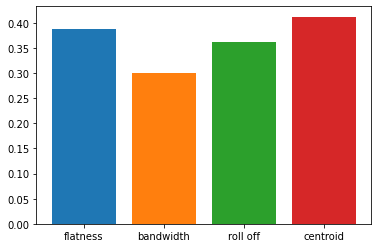

In [58]:
#flatness_rf_score, constrast_rf_score, bandwidth_rf_score, roll_off_rf_score, centroid_rf_score

plt.bar('flatness', flatness_rf_score)
plt.bar('bandwidth', bandwidth_rf_score)
plt.bar('roll off', roll_off_rf_score)
plt.bar('centroid', centroid_rf_score)
plt.show()

y_pred = rf.predict(x_test, y_test)

plt.figure(figsize=(10,8))
predicted= np.argmax(y_pred,axis=1)
cm=ConfusionMatrixDisplay(confusion_matrix(y_true=y_true, y_pred=predicted), display_labels=['Guitar', 'Drum', 'Violin', 'Piano'])#, display_labels = [False, True]) 
cm.plot()
plt.show()